# Data Analysis - Customer Revenue


## Conclusions & key findings:


Pareto Analysis: What percentage of users generate the majority of the revenue?
- In this case, the distribution does not follow the traditional 80/20 Pareto principle. 
- Instead, 55% of customers contribute to 80% of the revenue.


Key Implications:
1. Lower Revenue Concentration – Less reliance on a few high-value customers, reducing risk.
2. Higher Customer Dependence – Requires a larger customer base to sustain revenue.
3. Increased Costs – More customers mean higher acquisition and service costs.
4. Growth Opportunities – Potential for upselling.
5. Different Market Strategy – Likely a mass-market approach rather than premium-focused.

<br>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

cash_request = pd.read_parquet("cleaned_requests.parquet", engine="pyarrow")
fees = pd.read_parquet("cleaned_fees.parquet", engine="pyarrow")


In [8]:
fees.head(5)

# merge fees & cash_request
merged_data = pd.merge(fees, cash_request, left_on="cash_request_id", right_on="id", how="inner", suffixes=('_fees', '_cash_request'))

# for deleted accounts, fill the user_id with the deleted_account_id
cash_request["user_id"] = cash_request["user_id"].fillna(cash_request["deleted_account_id"])


with pd.option_context("display.max_columns", None):
    # display(merged_data.head(5))
    pass


In [9]:
# get total fees per customer
total_fees_per_customer = merged_data.groupby("user_id").agg({"total_amount": "sum"}).reset_index()

# display(total_fees_per_customer)

In [10]:
#
# Analysis on the top customers
#

def print_top_customers_info(n):
    # get the top "n" customers with the highest total fees
    top_customers = total_fees_per_customer.nlargest(n, "total_amount")


    # get the percentage of customers
    total_number_of_customers = total_fees_per_customer["user_id"].count()
    percentage_from_total_users = n / total_number_of_customers * 100
    print(f"Top {n} customers represent: {round(percentage_from_total_users, 2)}% of the total number of customers.")


    # check how much revenue generate the top "n" customers
    total_revenue = total_fees_per_customer["total_amount"].sum()
    top_customers_revenue = top_customers["total_amount"].sum()
    percentage_revenue = top_customers_revenue / total_revenue * 100
    print(f"Top {n} customers generate: {round(percentage_revenue, 2)}% of the total revenue. \n")


print_top_customers_info(10)
print_top_customers_info(20)
print_top_customers_info(30)
print_top_customers_info(40)
print_top_customers_info(50)


Top 10 customers represent: 0.11% of the total number of customers.
Top 10 customers generate: 1.2% of the total revenue. 

Top 20 customers represent: 0.23% of the total number of customers.
Top 20 customers generate: 2.01% of the total revenue. 

Top 30 customers represent: 0.34% of the total number of customers.
Top 30 customers generate: 2.69% of the total revenue. 

Top 40 customers represent: 0.45% of the total number of customers.
Top 40 customers generate: 3.32% of the total revenue. 

Top 50 customers represent: 0.56% of the total number of customers.
Top 50 customers generate: 3.89% of the total revenue. 



In [11]:
#
# Pareto Analysis
#
# (check how many customers generate 80% of the revenue)
#


# sort the total fees per customer in descending order
total_fees_per_customer = total_fees_per_customer.sort_values(by="total_amount", ascending=False)

# get the total revenue and the total number of customers
total_revenue = total_fees_per_customer["total_amount"].sum()
total_number_of_customers = len(total_fees_per_customer)

# calculate the cumulative sum and the cumulative percentage of the total fees
total_fees_per_customer["cumulative_sum"] = total_fees_per_customer["total_amount"].cumsum()
total_fees_per_customer['cumulative_percentage'] = total_fees_per_customer['cumulative_sum'] / total_revenue * 100

# Find the number of customers contributing to 80% of revenue
num_customers = (total_fees_per_customer["cumulative_sum"] <= 0.8 * total_revenue).sum()

print(f"Number of customers contributing to 80% of revenue: {num_customers}")
print(f"Percentage of customers contributing to 80% of revenue: {round(num_customers / total_number_of_customers * 100, 2)}%")


Number of customers contributing to 80% of revenue: 4841
Percentage of customers contributing to 80% of revenue: 54.56%


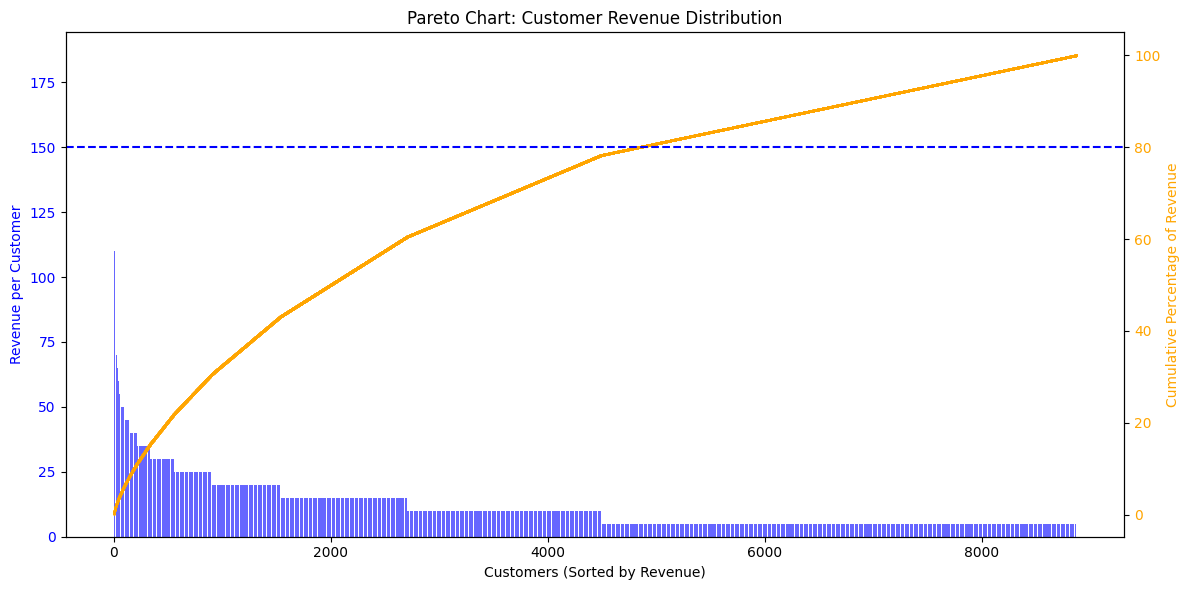

In [12]:
# 
# Display results from Pareto Analysis
# 

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for individual customer revenue
bars = ax1.bar(range(len(total_fees_per_customer)), total_fees_per_customer['total_amount'], color='b', alpha=0.6)
ax1.set_xlabel('Customers (Sorted by Revenue)')
ax1.set_ylabel('Revenue per Customer', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(range(len(total_fees_per_customer)), total_fees_per_customer['cumulative_percentage'], color='orange', marker='o', linewidth=1, markersize=1)
ax2.set_ylabel('Cumulative Percentage of Revenue', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add 80% line
ax2.axhline(y=80, color='blue', linestyle='--', label='80% Revenue Threshold')

plt.title('Pareto Chart: Customer Revenue Distribution')
plt.tight_layout()
plt.show()
